I. Set Up

In [2]:
# PYTHON Imports 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pathlib import Path
import glob
import ipywidgets as widgets
from IPython.display import clear_output
import random
import math
# ASTROPHY Imports
import astropy 
from astropy.table import Table
from astropy.io import fits
import astropy.stats as astats
import hepstats
from hepstats import *
# CIAO Imports
import ciao_contrib.runtool
from ciao_contrib.runtool import *
from ciao_contrib.runtool import search_csc, obsid_search_csc
from sherpa.astro import ui
import bxa.sherpa as bxa

# CUSTOM Imports
from data_exploration_functions import *
from data_extraction_functions import *
from data_representation_functions import *

def list_folders_fun(path):
    """
    DESCRIPTION: List folders in a given directory.
    INPUT: Directory path
    OUTPUT: Folder names in a given directory
    """
    folder_list = [f.name for f in Path(path).iterdir() if f.is_dir()]
    return folder_list

# Specify global path
global_path = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets'
global_folders = list_folders_fun(global_path)

# Select dataset
set_widget = widgets.Dropdown(options=global_folders[:],value=global_folders[0],description='Set :',disabled=False); set_widget

Dropdown(description='Set :', options=('Full', 'All', 'Full_extra', 'New', 'Bona'), value='Full')

II. Load Data

In [3]:
# from matplotlib.colors import LogNorm
# from sherpa.astro import ui
# Set ID
set_id = set_widget.value

df_eventfiles_input = pd.read_csv(f'{global_path}/{set_id}/eventfiles-input-{set_id[0:4]}.csv')
df_properties_input = pd.read_csv(f'{global_path}/{set_id}/properties-input-{set_id[0:4]}.csv')

df_properties_global = pd.read_csv(f'{global_path}/{set_id}/properties-{set_id[0:4]}.csv')
df_properties_global['obsreg_id'] = df_properties_global['obsid'].astype(str) + '_' + df_properties_global['region_id'].astype(str)

df_eventfiles_group = df_eventfiles_input.groupby('obsreg_id')
df_properties_group = df_properties_input.groupby('obsreg_id')

print("Number of Eventfiles: ", df_eventfiles_group.ngroups)
print("Number of Property Sets: ", df_properties_group.ngroups)

#print("ObsID and RegID: ", df_eventfiles_group.groups.keys())
df_properties_global.head()

Number of Eventfiles:  95473
Number of Property Sets:  95473


,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood_class,conf_flag,sat_src_flag,...,hard_hs_hilim,var_prob_b,var_prob_h,var_prob_m,var_prob_s,var_index_b,var_index_w,livetime,detector,obsreg_id
0,2CXO J000000.5-575830,0.002735,-57.975181,2.819565,1.667655,91.090421,8.522222,TRUE,True,False,...,-0.267958,0.085129,0.121377,0.376451,0.175421,0.0,NaN,30146.733203,ACIS-6,9335_26
1,2CXO J000001.7+003824,0.007280,0.640146,1.093394,0.871849,104.849964,5.485207,TRUE,False,False,...,0.269207,0.612624,0.585561,0.519756,0.678199,1.0,NaN,23719.527217,ACIS-7,11591_1
2,2CXO J000002.4+004444,0.010189,0.745732,0.746484,0.723548,34.468703,5.774224,TRUE,False,False,...,0.003123,0.425172,0.465109,0.489993,0.754087,0.0,NaN,23719.527217,ACIS-7,11591_22
3,2CXO J000002.4+321750,0.010280,32.297465,1.067836,0.944977,115.769199,5.028571,TRUE,False,False,...,0.222986,0.154076,0.177304,0.548595,NaN,0.0,NaN,24735.257397,ACIS-3,20515_8
4,2CXO J000002.9-350332,0.012314,-35.059185,0.855386,0.735828,172.590089,16.266113,TRUE,False,False,...,-0.377889,0.067012,0.113151,0.235485,0.080282,0.0,NaN,9937.243792,ACIS-6,15712_4


In [148]:
from crypt import methods
from logging.handlers import BaseRotatingHandler
from pyexpat import ErrorString
from tkinter import N
from tokenize import PlainToken
from ciao_contrib.runtool import *
import os
import glob
import numpy as np
import sys
from re import sub
import subprocess
import matplotlib.pyplot as plt
from scipy.stats import bootstrap
import numpy as np
import random
from scipy.stats import entropy
from astropy.stats import bayesian_blocks
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from matplotlib import axes
from astropy.stats import histogram
from statistics import mean, median, median_high
from scipy.stats import norm
from scipy import interpolate
from numpy import trapz
import astropy.stats as astats

def behr_hr(area,id,binning,conf = '68.00'):
    BEHR_DIR = '/Users/steven/Desktop/BBBB/BEHR'
    DATA_DIR = '/Users/steven/Desktop/CSCData/23022need/'
    evt_file = glob.glob(f'{DATA_DIR}*evt6*')[0]
    regevt = glob.glob(f'{DATA_DIR}*evt6_filtered*')[0]
    src_region = glob.glob(f'{DATA_DIR}*reg6*')[0]
    bkg_region = glob.glob(f'{DATA_DIR}*bkg6*')[0]
    bevt = glob.glob(f'{DATA_DIR}*evt6_back*')[0]

    with fits.open(regevt) as hdul:
        # Events dataframe
        events = hdul["Events"].data
        events_table = Table(events)
        events_cols = events.columns.names
        df_events = pd.DataFrame.from_records(events_table, columns=events_cols)
        df_events = df_events.sort_values(by=["time"])
        # GTI (Good Time Interval) dataframe
        gti = hdul["GTI"].data
        gti_table = Table(gti)
        gti_cols = gti.columns.names
        df_gti = pd.DataFrame.from_records(gti_table, columns=gti_cols)
        # Apply GTI filter to events
        gti_mask = np.zeros(len(df_events), dtype=bool)
        for i in range(len(df_gti)):
            start = df_gti.iloc[i]['START']
            stop = df_gti.iloc[i]['STOP']
            gti_mask |= (df_events["time"] >= start) & (df_events["time"] < stop)
        df_events = df_events[gti_mask]
        # Apply energy, pha, grade filters to events
        df_events = df_events[(df_events['pha']>40) & (df_events['grade']>=0) & (df_events['energy']>500) & (df_events['energy']<7000)]
        time = df_events.time.values[20:]
        start_time = min(time)
        src_times = time - start_time
        src_energies = df_events.energy.values[20:]

    with fits.open(bevt) as hdul:
        # Events dataframe
        bevents = hdul["Events"].data
        bevents_table = Table(bevents)
        bevents_cols = bevents.columns.names
        df_bevents = pd.DataFrame.from_records(bevents_table, columns=bevents_cols)
        df_bevents = df_bevents.sort_values(by=["time"])
        # GTI (Good Time Interval) dataframe
        bgti = hdul["GTI"].data
        bgti_table = Table(bgti)
        bgti_cols = bgti.columns.names
        df_bgti = pd.DataFrame.from_records(bgti_table, columns=bgti_cols)
        # Apply GTI filter to events
        bgti_mask = np.zeros(len(df_bevents), dtype=bool)
        for i in range(len(df_bgti)):
            start = df_bgti.iloc[i]['START']
            stop = df_bgti.iloc[i]['STOP']
            bgti_mask |= (df_bevents["time"] >= start) & (df_bevents["time"] < stop)
        df_bevents = df_bevents[bgti_mask]
        # Apply energy, pha, grade filters to events
        df_bevents = df_bevents[(df_bevents['pha']>40) & (df_bevents['grade']>=0) & (df_bevents['energy']>500) & (df_bevents['energy']<7000)]
        bkg_times = df_bevents.time.values - start_time
        bkg_energies = df_bevents.energy.values

    if binning == 'bb':
        bb_bins = astats.bayesian_blocks(src_times, fitness='events',p0 = 0.01) # p0 = 0.1
        bin_widths = bb_bins[1:] - bb_bins[:-1]
        counts, _ = np.histogram(src_times, bins=bb_bins)
        time_bin = (bb_bins[:-1] + bb_bins[1:]) / 2
    elif binning == 'fixed':
        bin_size = 500
        num_bins = int(src_times[-1] / bin_size) + 1
        binned_counts, bb_bins = np.histogram(src_times, bins=num_bins)
        time_bin = (bb_bins[:-1] + bb_bins[1:]) / 2
    elif binning == 'counts':
        count_per_bin = 10
        counts = np.ones(len(src_times))
        num_bins = len(src_times) // count_per_bin
        bb_bins = [src_times[i * count_per_bin] for i in range(num_bins)]
        bb_bins.append(src_times[-1])
        bb_bins = np.array(bb_bins)
        time_bin = (bb_bins[:-1] + bb_bins[1:]) / 2

    times_and_energies = np.column_stack((src_times,src_energies))
    bkg_te = np.column_stack((bkg_times,bkg_energies))
    # define soft/medium/hard bands
    soft_filter = times_and_energies[:,1] < 1200
    medium_filter = (times_and_energies[:,1] < 2000) *(times_and_energies[:,1] > 1200)
    hard_filter = times_and_energies[:,1] > 2000
    soft_medium_filter = times_and_energies[:,1] < 2000
    soft_filter_b = bkg_te[:,1] < 1200
    medium_filter_b = (bkg_te[:,1] < 2000) *(bkg_te[:,1] > 1200)
    hard_filter_b = bkg_te[:,1] > 2000
    soft_medium_filter_b = bkg_te[:,1] < 2000
    # generate data for each band
    soft_lc = times_and_energies[soft_filter]
    medium_lc = times_and_energies[medium_filter]
    hard_lc =times_and_energies[hard_filter]
    sm_lc = times_and_energies[soft_medium_filter]
    soft_b = bkg_te[soft_filter_b]
    medium_b = bkg_te[medium_filter_b]
    hard_b = bkg_te[hard_filter_b]
    sm_b = bkg_te[soft_medium_filter_b]
    #counts
    counts_s, _ = np.histogram(soft_lc[:,0], bins=   bb_bins)
    counts_m, _ = np.histogram(medium_lc[:,0], bins=   bb_bins)
    counts_h, _ = np.histogram(hard_lc[:,0], bins=   bb_bins)
    counts_sm, _ = np.histogram(sm_lc[:,0], bins=   bb_bins)
    counts_s_b, _ = np.histogram(soft_b[:,0], bins=   bb_bins)
    counts_m_b, _ = np.histogram(medium_b[:,0], bins=   bb_bins)
    counts_h_b, _ = np.histogram(hard_b[:,0], bins=   bb_bins)
    counts_sm_b, _ = np.histogram(sm_b[:,0], bins=   bb_bins)

    outfile = f'{DATA_DIR}behr' 
    for i in range(0,len(counts_s)):
        with open(outfile,'w') as writeto:
            writeto.write(f'cd {BEHR_DIR}')
            writeto.write(f'\n echo "softsrc={counts_sm[i]} hardsrc={counts_h[i]}   softbkg={counts_sm_b[i]}   hardbkg={counts_h_b[i]} softarea={area} outputPr=True algo=quad"')
            writeto.write(f'\n./BEHR softsrc={counts_sm[i]} hardsrc={counts_h[i]}   softbkg={counts_sm_b[i]}   hardbkg={counts_h_b[i]}  softarea={area} output={BEHR_DIR}/new/{i}_block_BEHRresults_{id} level={conf}')

        subprocess.run(f'bash {outfile}', shell = True)

    def behr_open(file):
        with open(file,'r') as data:
            contents = data.read()
            line = contents.splitlines()[2].split()
            print("Option: ", line[0])
            med = line[3]
            lower = line[4]
            upper = line[5]
        return med,upper,lower
    
    medians = []
    uppers = []
    lowers = []

    for i in range(0,len(counts_s)):
        file = f'{BEHR_DIR}/new/{i}_block_BEHRresults_{id}.txt'
        med,upper,lower = behr_open(file)
        uppers.append(upper)
        medians.append(med)
        lowers.append(lower)

    uppers = np.array(uppers).astype('float64')
    lowers = np.array(lowers).astype('float64')
    medians = np.array(medians).astype('float64')

    return time_bin, bb_bins, medians, uppers, lowers, src_times 


NameError: name 'medians' is not defined

Spectrum

In [9]:
obsid = '23022'
regionid = '122'
obsreg_id = obsid + '_' + regionid
selected = df_properties_global[df_properties_global['obsreg_id']==obsreg_id ]
pd.set_option('display.max_columns', None)
print(selected['flux_aper_b'].values)
selected.head()



[0.]


,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood_class,conf_flag,sat_src_flag,streak_src_flag,flux_aper_b,flux_aper_lolim_b,flux_aper_hilim_b,flux_aper_w,flux_aper_lolim_w,flux_aper_hilim_w,flux_aper_avg_b,flux_aper_avg_lolim_b,flux_aper_avg_hilim_b,flux_aper_avg_w,flux_aper_avg_lolim_w,flux_aper_avg_hilim_w,obsid,obi,gti_obs,gti_end,region_id,theta,phi,flux_significance_b,flux_significance_w,likelihood_b,likelihood_w,conf_code,extent_code,sat_src_flag.1,streak_src_flag.1,var_code,major_axis_b,minor_axis_b,pos_angle_b,major_axis_w,minor_axis_w,pos_angle_w,cnts_aper_b,cnts_aperbkg_b,cnts_aper_w,src_cnts_aper_b,src_cnts_aper_w,src_rate_aper_b,src_rate_aper_w,flux_aper_b.1,flux_aper_lolim_b.1,flux_aper_hilim_b.1,flux_aper_w.1,flux_aper_lolim_w.1,flux_aper_hilim_w.1,hard_hm,hard_hm_lolim,hard_hm_hilim,hard_ms,hard_ms_lolim,hard_ms_hilim,hard_hs,hard_hs_lolim,hard_hs_hilim,var_prob_b,var_prob_h,var_prob_m,var_prob_s,var_index_b,var_index_w,livetime,detector,obsreg_id
27751,2CXO J051117.2-672556,77.822016,-67.432396,1.859151,1.339932,5.1285,11.642147,TRUE,True,False,False,0.0,0.0,9.789457e-16,NaN,NaN,NaN,3.314104e-16,0.0,9.942313e-16,NaN,NaN,NaN,23022,0,2020-05-15T12:05:31,2020-05-15T19:03:13,122,11.745694,354.883179,11.642147,NaN,327.572054,NaN,15,0,False,False,28,4.864212,4.864212,0.0,NaN,NaN,NaN,219,716,NaN,192.076596,NaN,0.007765,NaN,1.915948e-13,1.651249e-13,2.180647e-13,NaN,NaN,NaN,0.7208,0.662711,0.777639,-0.276077,-0.491568,0.053092,0.607121,0.452842,0.785134,1.0,1.0,1.0,NaN,10.0,NaN,24734.882334,ACIS-8,23022_122


In [261]:
df_eventfiles_group_filtered = df_eventfiles_group.filter(lambda x: x.name in obsreg_id).groupby('obsreg_id')
for id_name, dfi in df_eventfiles_group_filtered:
    df = dfi
imperial = '#003E74'
imperial2 = '#002147'
darkblue = '#003170'
harvard = '#A51C30'
silver = '#777777'
silver2 = '#C0C0C0'
gold = '#cfbd62'

In [203]:
df.head()
cut = 20
time = df['time'].values[cut:] - min(df['time'].values[cut:])
counts = np.ones(len(time))

mflux_con = 2.9013e-11
# mflux_con = 1

col = 'black'

import statistics
from scipy import stats
import numpy as np
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting

bin_size = 12


binned_counts = [len(counts[i:i+bin_size]) for i in range(0, len(counts), bin_size)]
bin_edges = [time[i] for i in range(0, len(time) - len(time) % bin_size, bin_size)]
bin_edges.append(time[-1])
bin_edges = np.array(bin_edges)
time_stamps = (bin_edges[:-1] + bin_edges[1:]) / 2
time_stamps = [statistics.mean(time[i:i+bin_size]) for i in range(0, len(time)-bin_size+1, bin_size)]
time_durations = [time[i+bin_size] - time[i] for i in range(0, len(time)-bin_size, bin_size)]
time_durations.append(time[-1] - time[-bin_size])
count_rate = [count / duration * mflux_con for count, duration in zip(binned_counts, time_durations)] 

print(len(bin_edges))
print(time_durations)

15
[3.1409902572631836, 3.1409902572631836, 21.987051248550415, 37.6920622587204, 37.69203233718872, 43.97407257556915, 37.69203245639801, 56.53808331489563, 50.25605309009552, 113.07614696025848, 62.820093631744385, 69.10208427906036, 169.61421036720276, 782.110077381134]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


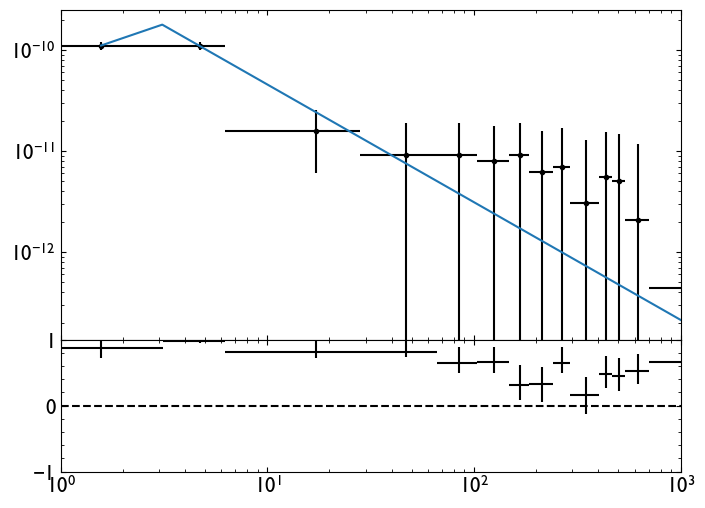

In [205]:
df.head()
cut = 20
time = df['time'].values[cut:] - min(df['time'].values[cut:])
counts = np.ones(len(time))

mflux_con = 2.9013e-11
# mflux_con = 1

col = 'black'

import statistics
from scipy import stats
import numpy as np
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting

bin_size = 12


binned_counts = [len(counts[i:i+bin_size]) for i in range(0, len(counts), bin_size)]
bin_edges = [time[i] for i in range(0, len(time) - len(time) % bin_size, bin_size)]
bin_edges.append(time[-1])
bin_edges = np.array(bin_edges)
time_stamps = (bin_edges[:-1] + bin_edges[1:]) / 2
# time_stamps = [statistics.mean(time[i:i+bin_size]) for i in range(0, len(time)-bin_size+1, bin_size)]
time_durations = [time[i+bin_size] - time[i] for i in range(0, len(time)-bin_size, bin_size)]
time_durations.append(time[-1] - time[-bin_size])
count_rate = [count / duration * mflux_con for count, duration in zip(binned_counts, time_durations)] 

low_limit_bins = bin_edges[:-1]
high_limit_bins = bin_edges[1:]

num_bootstrap = 1000000

filtered_data = np.array(count_rate)[~np.isinf(count_rate)]

# Function to calculate the desired statistic
def calculate_statistic(data):
    return np.mean(data)  # Change this to the desired statistic

# Bootstrap procedure
bootstrap_stats = []
for _ in range(num_bootstrap):
    bootstrap_sample = np.random.choice(filtered_data, size=len(filtered_data), replace=True)
    statistic = calculate_statistic(bootstrap_sample)
    bootstrap_stats.append(statistic)

error_bars = np.std(bootstrap_stats)
yerror = error_bars * np.ones(len(time_stamps))

# Define Font Settings
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
# plt.xlabel('Energy [keV]')
# plt.ylabel('Count Rate [1/s/keV]')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6),gridspec_kw={'height_ratios': [5, 2]},sharex=True)

ax1.plot(time_stamps,count_rate, color=col,linestyle='',marker='.')
ax1.set_yscale('log')
# ax1.set_ylim(0.01, 10)
ax2.set_xscale('log')
ax2.set_xlim(1, 1000)
ax1.tick_params(which='both', direction='in', top=True, right=True)
ax1.minorticks_on()
ax1.legend(loc='upper left', frameon=False, fontsize = 14)
# ax1.set_xlim([time[0],time[-1]])


# Add x-error bars using bin durations
# ax1.errorbar(time_stamps, count_rate, xerr=np.array(time_durations) / 2, yerr=poisson_errors,
#              fmt='none', ecolor=col, linewidth=1.5, capsize=0)

# # Add x-error bars as lines
# for x, y, yerr, xlo, xhi in zip(time_stamps, count_rate, poisson_errors, binned_start_time, binned_end_time):
#     ax1.errorbar(x, y, yerr=yerr, xerr=[[x - xlo], [xhi - x]], fmt='none', ecolor=col, linewidth=1.5, capsize=0)

for x, y, yerr, xlo, xhi in zip(time_stamps, count_rate, yerror, low_limit_bins, high_limit_bins):
    ax1.errorbar(x, y, yerr=yerr, xerr=[[x - xlo], [xhi - x]], fmt='none', ecolor=col, linewidth=1.5, capsize=0)


Medians = [0.867845, 0.977137, 0.816879, 0.815626, 0.651483, 0.656568, 0.3199, 0.320866, 0.648705, 0.161376, 0.484221, 0.44937, 0.522869, 0.663523]

Uppers = [1.0, 1.0, 0.990015, 0.995501, 0.893463, 0.889611, 0.614563, 0.590829, 0.894137, 0.434928, 0.745282, 0.724412, 0.780634, 0.902517]

Lowers = [0.718646, 0.952188, 0.720669, 0.729991, 0.499303, 0.498375, 0.090133, 0.060656, 0.495605, -0.126744, 0.264821, 0.225405, 0.32739, 0.491345]


# Compute and plot the residuals on ax2
ax2.plot(time_stamps, Medians, color=col,linestyle='')
ax2.axhline(0, color='black', linestyle='--') 
# ax2.plot(delchi_plot.x, delchi_plot.y, color='white',linewidth=3)
# ax2.set_xlabel('Energy [keV]')
# ax2.set_ylabel(r'Residual [(D-M)/$\sigma$]',labelpad=14)
ax2.set_ylim([-1,1])
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.minorticks_on()

# Add x-error bars as lines
for x, y, ylo,yhi, xlo, xhi in zip(time_stamps, Medians, Lowers, Uppers, low_limit_bins, high_limit_bins):
    ax2.errorbar(x, y, yerr=[[y - ylo], [yhi - y]], xerr=[[x - xlo], [xhi - x]], fmt='none', ecolor=col, linewidth=1.5, capsize=0)

broken_power_law = models.BrokenPowerLaw1D()
# Create a fitter object and set the fit method
fitter = fitting.LevMarLSQFitter()

x = np.array(time_stamps)
y = np.array(count_rate)/mflux_con

# Remove non-finite values
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]

# Perform the fit
fitted_model = fitter(broken_power_law, x, y)
a_1 = fitted_model.amplitude.value
b_1 = fitted_model.alpha_1.value
x_0 = fitted_model.x_break.value
a_2 = fitted_model.alpha_2.value

# Generate a higher-resolution x-values for the plot
x_plot = np.linspace(min(x), max(x), 10000)

# Compute the fitted function values
y_fit = fitted_model(x_plot) * mflux_con 

ax1.plot(x_plot, y_fit, label='Broken Power Law Fit')

plt.subplots_adjust(hspace=0)
# plt.tight_layout()
plt.show()



In [273]:
df.head()
cut = 0

cut3 = 20 

time_start = df['time'].values[cut3]
time_end = df['time'].values[-1]

time = df['time'].values[cut:] - min(df['time'].values[cut:])
time3 = time[cut3]
counts = np.ones(len(time))

print(time_start)
print(time_end)

705955014.5170381
705956503.3530185


705955014.5170381
[  2.19869318   3.14099026   5.02558441  21.35882332  53.71116931
  85.43530521 115.90303909 156.4220035  191.91534373 239.3445066
 279.54935504 360.27316095 431.88805227 487.16972466 546.22059726
 715.52072049]
[3.18370933        inf 3.18370933 0.35374361 0.35374386 0.39796225
 0.28942687 0.31836972 0.24489964 0.26530799 0.26530799 0.13265394
 0.24489964 0.13842154 0.18727618 0.0225794 ]


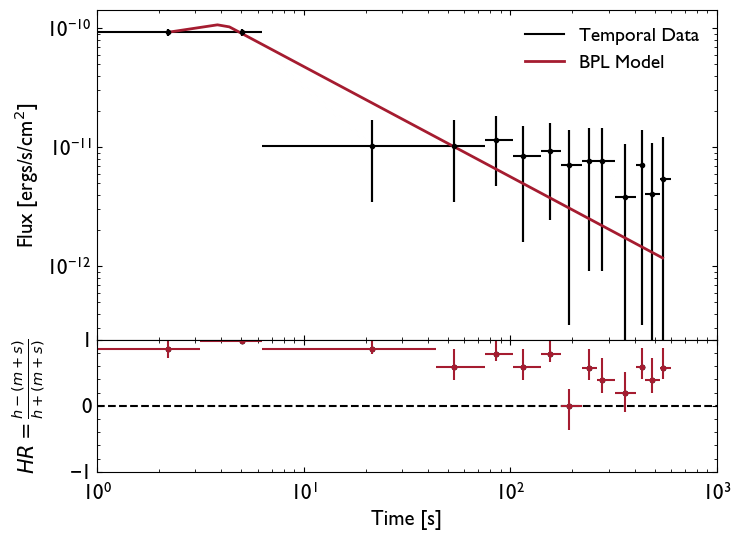

Broken power law ampl:  1.087695285259126e-10
Model: BrokenPowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
       amplitude          x_break            alpha_1            alpha_2      
    ---------------- ----------------- ------------------- ------------------
    3.74899281445947 4.111225499975534 -0.2611453509482287 0.9261878012042678
Power law ampl:  7.216542904266507e-11
Model: PowerLaw1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
        amplitude             x_0              alpha       
    ------------------ ----------------- ------------------
    2.4873480523442963 4.126643052235086 0.5779102567561332


In [337]:
df.head()
cut = 0
time = df['time'].values[cut:] - min(df['time'].values[cut:])
counts = np.ones(len(time))

bin_size = 10


binned_counts = [len(counts[i:i+bin_size]) for i in range(0, len(counts), bin_size)]
bin_edges = [time[i] for i in range(0, len(time) - len(time) % bin_size, bin_size)]
bin_edges.append(time[-1])
bin_edges = np.array(bin_edges)
time_stamps = (bin_edges[:-1] + bin_edges[1:]) / 2
time_stamps = [statistics.mean(time[i:i+bin_size]) for i in range(0, len(time)-bin_size+1, bin_size)]
time_durations = [time[i+bin_size-1] - time[i] for i in range(0, len(time)-bin_size+1, bin_size)]
count_rate = [count / duration * mflux_con for count, duration in zip(binned_counts, time_durations)] 

low_limit_bins = bin_edges[:-1]
high_limit_bins = bin_edges[1:]


num_bootstrap = 1000000

filtered_data = np.array(count_rate)[~np.isinf(count_rate)]

# Function to calculate the desired statistic
def calculate_statistic(data):
    return np.mean(data)  # Change this to the desired statistic

# Bootstrap procedure
bootstrap_stats = []
for _ in range(num_bootstrap):
    bootstrap_sample = np.random.choice(filtered_data, size=len(filtered_data), replace=True)
    statistic = calculate_statistic(bootstrap_sample)
    bootstrap_stats.append(statistic)

error_bars = np.std(bootstrap_stats)

df.head()
cut = 20
cut2 = -1
print(min(df['time'].values[cut:cut2]))
time = df['time'].values[cut:cut2] - min(df['time'].values[cut:cut2])
counts = np.ones(len(time))

mflux_con = 2.9013e-11
# mflux_con = 1

col = 'black'
col2 = harvard
colfit = harvard

import statistics
from scipy import stats
import numpy as np
from scipy.optimize import curve_fit
from astropy.modeling import models, fitting

bin_size = 10


binned_counts = [len(counts[i:i+bin_size]) for i in range(0, len(counts), bin_size)]
bin_edges = [time[i] for i in range(0, len(time) - len(time) % bin_size, bin_size)]
bin_edges.append(time[-1])
bin_edges = np.array(bin_edges)
time_stamps = (bin_edges[:-1] + bin_edges[1:]) / 2
time_stamps = [statistics.mean(time[i:i+bin_size]) for i in range(0, len(time)-bin_size+1, bin_size)]
time_durations = [time[i+bin_size-1] - time[i] for i in range(0, len(time)-bin_size+1, bin_size)]
count_rate = [count / duration * mflux_con for count, duration in zip(binned_counts, time_durations)] 

low_limit_bins = bin_edges[:-1]
high_limit_bins = bin_edges[1:]

yerror = error_bars * np.ones(len(time_stamps))


# Define Font Settings
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
# plt.xlabel('Energy [keV]')
# plt.ylabel('Count Rate [1/s/keV]')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6),gridspec_kw={'height_ratios': [5, 2]},sharex=True)

ax1.plot(time_stamps[:-1],count_rate[:-1], color=col,linestyle='-',label='Temporal Data')
ax1.plot(time_stamps[:-1],count_rate[:-1], color='white',linewidth=3)
ax1.errorbar(time_stamps[:-1],count_rate[:-1], yerr=error_bars,xerr = None, fmt='.', color = col,linewidth = 1.5,capsize = 0) #capsize 2

ax1.set_yscale('log')
# ax1.set_ylim(0.01, 10)
ax2.set_xscale('log')
ax2.set_xlim(1, 1000)
ax1.tick_params(which='both', direction='in', top=True, right=True)
ax1.minorticks_on()
# ax1.set_xlim([time[0],time[-1]])
ax1.set_ylabel(r'Flux [ergs/s/cm$^2$]')


# Add x-error bars using bin durations
# ax1.errorbar(time_stamps, count_rate, xerr=np.array(time_durations) / 2, yerr=poisson_errors,
#              fmt='none', ecolor=col, linewidth=1.5, capsize=0)

# # Add x-error bars as lines
# for x, y, yerr, xlo, xhi in zip(time_stamps, count_rate, poisson_errors, binned_start_time, binned_end_time):
#     ax1.errorbar(x, y, yerr=yerr, xerr=[[x - xlo], [xhi - x]], fmt='none', ecolor=col, linewidth=1.5, capsize=0)

for x, y, yerr, xlo, xhi in zip(time_stamps[:-1], count_rate[:-1], yerror[:-1], low_limit_bins[:-1], high_limit_bins[:-1]):
    ax1.errorbar(x, y, yerr=yerr, xerr=[[x - xlo], [xhi - x]], fmt='none', ecolor=col, linewidth=1.5, capsize=0)


Medians = [0.867845, 2, 0.977137, 0.862513, 0.582523, 0.779779, 0.58874, 0.778869, -0.009053, 0.576807, 0.38957, 0.199052, 0.588001, 0.38957, 0.579521, 0.551596]
Uppers = [1, 2, 1, 0.99662, 0.860491, 0.995226, 0.860688, 0.983612, 0.256011, 0.866175, 0.726596, 0.510784, 0.874731, 0.726596, 0.87186, 0.771411]
Lowers = [0.718646, 2, 0.952188, 0.791897, 0.398656, 0.678797, 0.398903, 0.65955, -0.359851, 0.398656, 0.187087, -0.095126, 0.400866, 0.187087, 0.403866, 0.381117]

# Compute and plot the residuals on ax2
ax2.plot(time_stamps[:-1], Medians[:-1], color=col,linestyle='',marker='.')
ax2.axhline(0, color='black', linestyle='--') 
# ax2.plot(delchi_plot.x, delchi_plot.y, color='white',linewidth=3)
# ax2.set_xlabel('Energy [keV]')
# ax2.set_ylabel(r'Residual [(D-M)/$\sigma$]',labelpad=14)
ax2.set_ylim([-1,1])
ax2.tick_params(which='both', direction='in', top=True, right=True)
ax2.minorticks_on()
ax2.xaxis.set_tick_params(pad=8)
ax2.set_xlabel(r'Time [s]')
ax2.set_ylabel(r'$HR = \frac{h - (m+s)}{h + (m+s)}$',labelpad=17)

ax2.plot(time_stamps[:-1], Medians[:-1], color=col,linestyle='',marker='.')
ax2.errorbar(time_stamps[:-1], Medians[:-1], yerr=None,xerr = None, fmt='.', color = col2,linewidth = 1.5,capsize = 0) #capsize 2
# Add x-error bars as lines
for x, y, ylo,yhi, xlo, xhi in zip(time_stamps[:-1], Medians[:-1], Lowers[:-1], Uppers[:-1], low_limit_bins[:-1], high_limit_bins[:-1]):
    ax2.errorbar(x, y, yerr=[[y - ylo], [yhi - y]], xerr=[[x - xlo], [xhi - x]], fmt='none', ecolor=col2, linewidth=1.5, capsize=0)

broken_power_law = models.BrokenPowerLaw1D()
power_law = models.PowerLaw1D()
# Create a fitter object and set the fit method
fitter = fitting.LevMarLSQFitter()

x = np.array(time_stamps)
y = np.array(count_rate)/mflux_con

print(x)
print(y)

# Remove non-finite values
mask = np.isfinite(x) & np.isfinite(y)
x2 =x[mask]
y2 = y[mask]
x = x[mask]
y = y[mask]

# Perform the fit
fitted_model = fitter(broken_power_law, x[:-1], y[:-1])
ampl = fitted_model.amplitude.value
alpha_1 = fitted_model.alpha_1.value
x_0 = fitted_model.x_break.value
alpha_2 = fitted_model.alpha_2.value

# error1 = fitter['fit_info']


# Perform the fit
fitted_model2 = fitter(power_law, x[:-1], y[:-1])
a = fitted_model2.amplitude.value
b = fitted_model2.alpha.value

# error2 = fitter['fit_info']

# Generate a higher-resolution x-values for the plot
x_plot = np.linspace(min(x[:-1]), max(x[:-1]), 1000)

# Compute the fitted function values
y_fit = fitted_model(x_plot) * mflux_con 
y_fit2 = fitted_model2(x_plot) * mflux_con 

# ax1.plot(x_plot, y_fit, color=colfit, label='Model (M)',linewidth = 2)
ax1.plot(x_plot, y_fit, color=colfit, label='BPL Model',linewidth = 2)
ax1.legend(loc='upper right', frameon=False, fontsize = 14)

plt.subplots_adjust(hspace=0)
# plt.tight_layout()
plt.show()

# print('Broken power law slope 1: ', alpha_1)
# print('Broken power law slope 2: ', alpha_2)
# print('Broken power law breakpoint: ',x_0)
print('Broken power law ampl: ',ampl* mflux_con)
# ampl = fitted_model.amplitude.value
print(fitted_model)
# print('Power law slope : ',b)
print('Power law ampl: ',a* mflux_con)
print(fitted_model2)




In [330]:
xxx = df['time'].values - min(df['time'].values)

print(xxx)


[    0.            62.82073379  1284.68307793  3404.87710679
  4406.86335778  4702.11930561  4733.52949762  5559.61745775
  5722.95034766  6187.82076585  6263.20514059  9178.06386757
 12111.76373577 13132.59040785 14681.10579193 15362.70376337
 16710.19472516 20045.94114792 21826.89058614 22634.12873507
 22634.12873507 22634.12873507 22634.12873507 22637.26972532
 22637.26972532 22637.26972532 22637.26972532 22637.26972532
 22637.26972532 22637.26972532 22637.26972532 22637.26972532
 22637.26972532 22637.26972532 22637.26972532 22637.26972532
 22637.26972532 22637.26972532 22637.26972532 22637.26972532
 22637.26972532 22637.26972532 22637.26972532 22637.26972532
 22640.41071558 22640.41071558 22640.41071558 22640.41071558
 22640.41071558 22640.41071558 22640.41071558 22643.55173576
 22646.69275582 22646.69275582 22652.97476614 22659.25677657
 22662.39776683 22665.53875709 22668.67977715 22668.67977715
 22678.10279775 22678.10279775 22678.10279775 22681.24379802
 22681.24379802 22690.66

In [298]:
print(x2[1:])
print(y2[1:])

y_predicted = fitted_model(x2[1:]) #* mflux_con  # Fitted model values
y_predicted2 = fitted_model2(x2[1:]) #* mflux_con  # Fitted model values
log_likelihood = -np.sum(stats.poisson.logpmf(y2[1:], mu=y_predicted))
log_likelihood2 = -np.sum(stats.poisson.logpmf(y2[1:], mu=y_predicted2))
n_data = len(y2)  # Number of data points
dof = n_data - 2
dof2 = n_data - 4
bic = -2 * log_likelihood + dof * np.log(n_data)
bic2 = -2 * log_likelihood2 + dof2 * np.log(n_data)

print('Log Likelihood BPL:', log_likelihood)
print('Degrees of Freedom (dof) BPL:', dof)
print('Bayesian Information Criterion (BIC) BPL:', bic)

print('Log Likelihood PL:', log_likelihood2)
print('Degrees of Freedom (dof) PL:', dof2)
print('Bayesian Information Criterion (BIC) PL:', bic2)


[  5.02558441  21.35882332  53.71116931  85.43530521 115.90303909
 156.4220035  191.91534373 239.3445066  279.54935504 360.27316095
 431.88805227 487.16972466 546.22059726 715.52072049]
[3.18370933 0.35374361 0.35374386 0.39796225 0.28942687 0.31836972
 0.24489964 0.26530799 0.26530799 0.13265394 0.24489964 0.13842154
 0.18727618 0.0225794 ]
Log Likelihood BPL: inf
Degrees of Freedom (dof) BPL: 13
Bayesian Information Criterion (BIC) BPL: -inf
Log Likelihood PL: inf
Degrees of Freedom (dof) PL: 11
Bayesian Information Criterion (BIC) PL: -inf


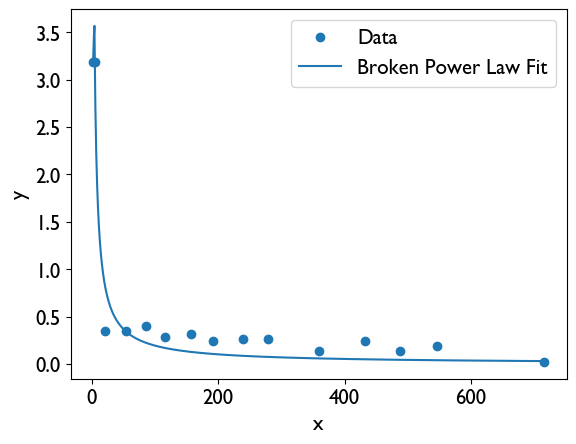

In [175]:
from astropy.modeling import models, fitting
broken_power_law = models.BrokenPowerLaw1D()
# Create a fitter object and set the fit method
fitter = fitting.LevMarLSQFitter()

x = np.array(time_stamps)
y = np.array(count_rate)/mflux_con

# Remove non-finite values
mask = np.isfinite(x) & np.isfinite(y)
x = x[mask]
y = y[mask]

# Perform the fit
fitted_model = fitter(broken_power_law, x, y)
a_1 = fitted_model.amplitude.value
b_1 = fitted_model.alpha_1.value
x_0 = fitted_model.x_break.value
a_2 = fitted_model.alpha_2.value

# Generate a higher-resolution x-values for the plot
x_plot = np.linspace(min(x), max(x), 1000)

# Compute the fitted function values
y_fit = fitted_model(x_plot)

# Plot the data and the fitted function
plt.scatter(x, y, label='Data')
plt.plot(x_plot, y_fit, label='Broken Power Law Fit')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

In [170]:
print(y)

[9.23689589e-11 9.23689589e-11 1.02631635e-11 1.02631707e-11
 1.15460787e-11 8.39714178e-12 9.23686080e-12 7.10527335e-12
 7.69738074e-12 7.69738072e-12 3.84868884e-12 7.10527337e-12
 4.01602400e-12 5.43344386e-12 6.55096055e-13]


Time duration:  705931574.7065945 705956549.2084681
Column Names of lc3: ['Time', 'COUNT_RATE', 'COUNT_RATE_ERR', 'Minus_3Sig', 'Plus_3Sig']
Column Names of bg3: ['Time', 'COUNT_RATE', 'COUNT_RATE_ERR', 'Minus_3Sig', 'Plus_3Sig']
Time duration:  705931574.7065945 705956549.2084681


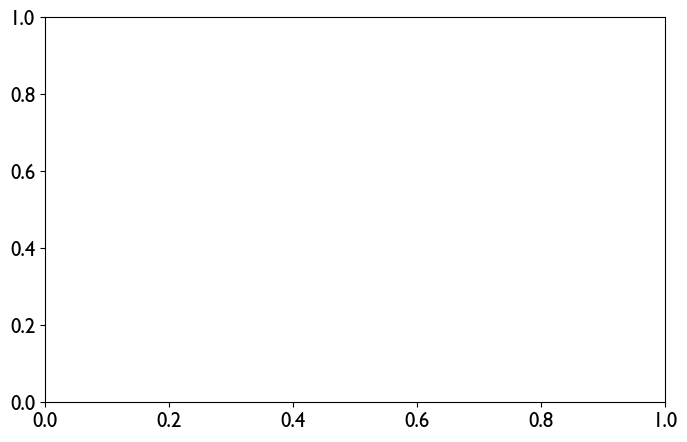

In [14]:
obsid = '23022'
regionid = '122'
pha_folder = '/Users/steven/Library/Mobile Documents/com~apple~CloudDocs/0-CfA/4-Data/Datasets/Full/spectrum_files/'



obsid = id_name.split("_")[0]
regionid = id_name.split("_")[1]
pha_filename = [spec for spec in glob.iglob(f'{pha_folder}/acisf*pha3.fits.gz') if str(obsid) in spec and str(regionid) in spec][0]
lc_filename = [lcurve for lcurve in glob.iglob(f'{pha_folder}/acisf*lc3.fits.gz') if str(obsid) in lcurve and str(regionid) in lcurve][0]
# Define Font Settings
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
# Create plot
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

with fits.open(lc_filename) as hdul_lc:
    lc3 = hdul_lc[1].data
    bg3 = hdul_lc[2].data
    print('Time duration: ', min(lc3['Time']), max(lc3['Time']))
    time = lc3['Time'] - min(lc3['Time'])
    countrate = lc3['COUNT_RATE']
    y_err = lc3['COUNT_RATE_ERR']

    lc3 = hdul_lc[1].data
    bg3 = hdul_lc[2].data
    
    # Get column names of lc3
    lc3_column_names = lc3.columns.names
    print("Column Names of lc3:", lc3_column_names)
    
    # Get column names of bg3
    bg3_column_names = bg3.columns.names
    print("Column Names of bg3:", bg3_column_names)
    
    # Rest of your code
    print('Time duration: ', min(lc3['Time']), max(lc3['Time']))
    time = lc3['Time'] - min(lc3['Time'])
    countrate = lc3['COUNT_RATE']
    backrate = bg3['COUNT_RATE']


In [153]:
print(time)

[   0.            0.            0.            3.14099026    3.14099026
    3.14099026    3.14099026    3.14099026    3.14099026    3.14099026
    3.14099026    3.14099026    3.14099026    3.14099026    3.14099026
    3.14099026    3.14099026    3.14099026    3.14099026    3.14099026
    3.14099026    3.14099026    3.14099026    3.14099026    6.28198051
    6.28198051    6.28198051    6.28198051    6.28198051    6.28198051
    6.28198051    9.42300069   12.56402075   12.56402075   18.84603107
   25.12804151   28.26903176   31.41002202   34.55104208   34.55104208
   43.97406268   43.97406268   43.97406268   47.11506295   47.11506295
   56.53806353   56.53806353   59.67905378   65.96109402   72.24310434
   75.3840946    75.3840946    78.52511466   81.66610491   81.66610491
   84.80709517   91.08910561   91.08910561   94.23012578  100.5121063
  103.65312636  106.79411662  106.79411662  109.93513668  109.93513668
  109.93513668  109.93513668  131.922158    131.922158    138.20416856
  141.3

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


33 34 16


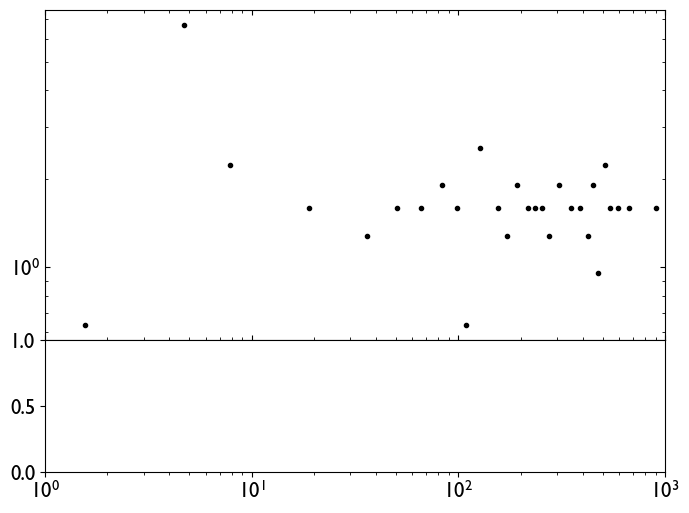

In [66]:
df.head()
time = df['time'].values[21:] - min(df['time'].values[21:])
counts = np.ones(len(time))

mflux_con = 2.9013e-11

col = 'black'

import statistics

count_per_bin = 5
counts = np.ones(len(time))
num_bins = len(time) // count_per_bin
bb_bins = [time[i * count_per_bin] for i in range(num_bins)]
bb_bins.append(time[-1])
bb_bins = np.array(bb_bins)
time_bin = (bb_bins[:-1] + bb_bins[1:]) / 2
binned_counts, _ = np.histogram(time, bins=bb_bins, weights=counts)
time_bin_size = bb_bins[1] - bb_bins[0]
count_rate = binned_counts / time_bin_size
poisson_errors = [math.sqrt(c) for c in count_rate]

# binned_counts = [len(counts[i:i+bin_size]) for i in range(0, len(counts), bin_size)]
# time_stamps = [statistics.mean(time[i:i+count_per_bin]) for i in range(0, len(time)-count_per_bin e+1, count_per_bin )]
# time_durations = [time[i+bin_size-1] - time[i] for i in range(0, len(time)-bin_size+1, bin_size)]
# count_rate = [count / duration for count, duration in zip(binned_counts, time_durations)]


binned_start_time = [time[i] for i in range(0, len(time), count_per_bin)]
end_time_bins = [time[i+count_per_bin-1] for i in range(0, len(time)-count_per_bin+1, count_per_bin)]

# # Print the binned start time, number of bins, time stamp, time duration, and count rate for each bin
# for start_time, count, time_stamp, duration, rate in zip(binned_start_time, binned_counts, time_stamps, time_durations, count_rate):
#     print("Start Time: ", start_time)
#     print("Number of Bins: ", count)
#     print("Time Stamp: ", time_stamp)
#     print("Time Duration: ", duration)
#     print("Count Rate: ", rate)
#     print()


# Define Font Settings
plt.rcParams.update({'font.size': 15})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Gill Sans'
# plt.xlabel('Energy [keV]')
# plt.ylabel('Count Rate [1/s/keV]')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6),gridspec_kw={'height_ratios': [5, 2]},sharex=True)

ax1.plot(time_bin,count_rate, color=col,linestyle='',marker='.')
ax1.set_yscale('log')
# ax1.set_ylim(0.01, 10)
ax2.set_xscale('log')
ax2.set_xlim(1, 1000)
ax1.tick_params(which='both', direction='in', top=True, right=True)
ax1.minorticks_on()
ax1.legend(loc='upper left', frameon=False, fontsize = 14)
# ax1.set_xlim([time[0],time[-1]])

print(len(time_bin), len(binned_start_time), len(time_durations))

# # Add x-error bars using bin durations
# ax1.errorbar(time_stamps, count_rate, xerr=np.array(time_durations) / 2, yerr=poisson_errors,
#              fmt='none', ecolor=col, linewidth=1.5, capsize=0)

# # # Add x-error bars as lines
# for x, y, yerr, xlo, xhi in zip(time_stamps, count_rate, poisson_errors, binned_start_time, binned_end_time):
#     ax1.errorbar(x, y, yerr=yerr, xerr=[[x - xlo], [xhi - x]], fmt='none', ecolor=col, linewidth=1.5, capsize=0)


plt.subplots_adjust(hspace=0)
# plt.tight_layout()
plt.show()